### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.simplefilter("ignore")


### 2. Load & Clean Data

In [2]:
df_raw = pd.read_csv("GFS.csv")

cols = df_raw.columns
year_col = next((c for c in cols if 'year' in c.lower()), 'Year')
quarter_col = next((c for c in cols if 'quarter' in c.lower()), 'Quarter')

for c in cols:
    if c not in [year_col, quarter_col]:
        df_raw[c] = pd.to_numeric(df_raw[c].astype(str).str.replace(",",""), errors='coerce')

quarter_map = {"Q1":"01-01","Q2":"04-01","Q3":"07-01","Q4":"10-01"}
df_raw["Date"] = pd.to_datetime(df_raw[year_col].astype(str) + "-" + df_raw[quarter_col].map(quarter_map))
df = df_raw.set_index("Date").sort_index()

### 3. Create Totals

In [3]:
# ================================
# DEFINE REVENUE & EXPENSE COLUMNS
# ================================
revenue_cols = ["Taxes","Social contributions","Grants","Other revenue"]

expense_cols = [
    "Compensation of employees","Use of goods and services",
    "Consumption of fixed capital","Interest","Subsidies",
    "Grants.1","Social benefits","Other expense"
]


# =======================================
# SCALE ALL NUMERIC COLUMNS EXCEPT YEAR
# divide by 1000 then multiply by 1,000,000
# (Net effect = multiply by 1000)
# =======================================

# Get all numeric columns except "Year"
numeric_cols = df.select_dtypes(include=['number']).columns
numeric_cols = [col for col in numeric_cols if col != "Year"]

# Apply scaling
df[numeric_cols] = df[numeric_cols] / 1000
df[numeric_cols] = df[numeric_cols] * 1_000_000


In [4]:
# ========================================
# RE-COMPUTE TOTAL REVENUE & EXPENDITURE
# ========================================
df["Total_Revenue"] = df[revenue_cols].sum(axis=1)
df["Total_Expenditure"] = df[expense_cols].sum(axis=1)
df.head()

,Year,Quarter,Taxes,Social contributions,Grants,Other revenue,Compensation of employees,Use of goods and services,Consumption of fixed capital,Interest,Subsidies,Grants.1,Social benefits,Other expense,Total Revenue,Total Expenses,Total_Revenue,Total_Expenditure
Date,,,,,,,,,,,,,,,,,,
2012-01-01,2012,Q1,74908300.0,520400.0,0.0,12273600.0,9306400.0,9073500.0,694300.0,278600.0,1758600.0,545600.0,8076200.0,36801000.0,87702300.0,66534200.0,87702300.0,66534200.0
2012-04-01,2012,Q2,82902700.0,903000.0,0.0,15339000.0,12291100.0,10879800.0,822300.0,399100.0,2735200.0,496300.0,17016200.0,33228200.0,99144700.0,77868100.0,99144700.0,77868200.0
2012-07-01,2012,Q3,71382700.0,415300.0,0.0,18812400.0,9143600.0,7461700.0,846400.0,662600.0,1828100.0,22900.0,9299700.0,37671600.0,90610500.0,66936600.0,90610400.0,66936600.0
2012-10-01,2012,Q4,73100300.0,832100.0,0.0,27845200.0,10290000.0,13030200.0,1113900.0,2979500.0,2129100.0,1532600.0,15657800.0,38681700.0,101777700.0,85414800.0,101777600.0,85414800.0
2013-01-01,2013,Q1,80061100.0,872400.0,0.0,16285900.0,10186000.0,8410700.0,721200.0,176400.0,2158100.0,4129000.0,8212900.0,41402600.0,97219400.0,75396800.0,97219400.0,75396900.0


### 4. Train-Test Split

In [5]:
horizon = 8
train_df = df.iloc[:-horizon]
test_df = df.iloc[-horizon:]
target_vars = ["Total_Revenue","Total_Expenditure"]

### 5. Evaluation Function

In [6]:
def eval_mae(actual, pred):
    return mean_absolute_error(actual, pred)


### 6. Seasonal Naive

In [7]:
def seasonal_naive(train, horizon, season_length=4):
    last_season = train[-season_length:]
    reps = int(np.ceil(horizon/season_length))
    forecast = np.tile(last_season, reps)[:horizon]
    return pd.Series(forecast, index=train.index[-horizon:])

### 7. ARIMA, ETS, Seasonal Naive Forecasting


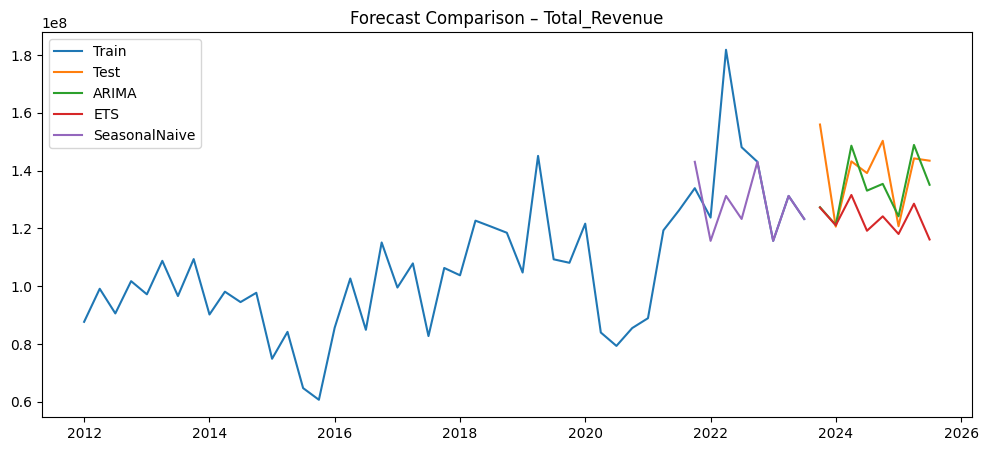

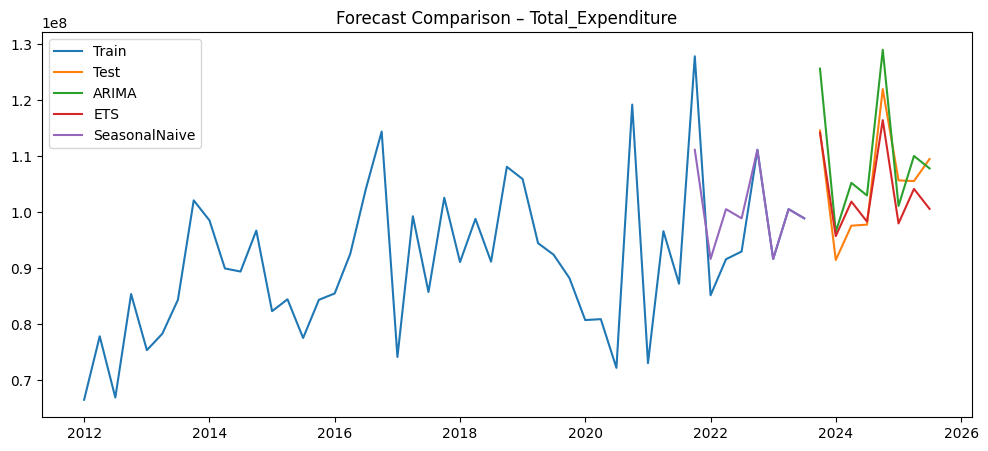

In [8]:
warnings.simplefilter("ignore")

results = {}

for target in target_vars:
    y_train = train_df[target]
    y_test = test_df[target]
    forecast_index = test_df.index
    
    # ARIMA
    arima_model = ARIMA(y_train, order=(1,1,1), seasonal_order=(1,1,1,4),
                        enforce_stationarity=False, enforce_invertibility=False).fit()
    arima_pred = arima_model.forecast(len(y_test))
    arima_pred = pd.Series(arima_pred.values, index=forecast_index)
    results[f"ARIMA_{target}"] = eval_mae(y_test, arima_pred)

    # ETS
    ets_model = ExponentialSmoothing(y_train, trend="add", seasonal="add", seasonal_periods=4,
                                     initialization_method="estimated").fit()
    ets_pred = ets_model.forecast(len(y_test))
    ets_pred = pd.Series(ets_pred.values, index=forecast_index)
    results[f"ETS_{target}"] = eval_mae(y_test, ets_pred)

    # Seasonal Naive
    sn_pred = seasonal_naive(y_train, len(y_test))
    results[f"SeasonalNaive_{target}"] = eval_mae(y_test, sn_pred)

    # Visualization
    plt.figure(figsize=(12,5))
    plt.plot(y_train, label="Train")
    plt.plot(y_test, label="Test")
    plt.plot(arima_pred, label="ARIMA")
    plt.plot(ets_pred, label="ETS")
    plt.plot(sn_pred, label="SeasonalNaive")
    plt.title(f"Forecast Comparison – {target}")
    plt.legend()
    plt.show()


### 8. Tree-Based Models with Lag Features

In [9]:
def create_lag_features(series, lags=4):
    df_lags = pd.DataFrame()
    for i in range(1, lags+1):
        df_lags[f"lag_{i}"] = series.shift(i)
    df_lags["target"] = series.values
    df_lags = df_lags.dropna()
    return df_lags


def forecast_tree_model(series, horizon=8, lags=4, model_type="RF"):
    df_lags = create_lag_features(series, lags)
    X = df_lags.drop("target", axis=1).values
    y = df_lags["target"].values

    if model_type=="RF":
        model = RandomForestRegressor(n_estimators=200, random_state=42)
    else:
        model = GradientBoostingRegressor(n_estimators=200, random_state=42)

    model.fit(X, y)
    last_vals = series.values[-lags:].tolist()
    preds = []
    for _ in range(horizon):
        X_pred = np.array(last_vals[-lags:]).reshape(1,-1)
        next_val = model.predict(X_pred)[0]
        preds.append(next_val)
        last_vals.append(next_val)
    
    return pd.Series(preds, index=pd.date_range(start=series.index[-1]+pd.offsets.QuarterBegin(), periods=horizon, freq='QS'))

### 9. LSTM Model

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size,1)
    def forward(self,x):
        out,_ = self.lstm(x)
        out = self.fc(out[:,-1,:])
        return out


def prepare_lstm_data(series, seq_length=8):
    X, y = [], []
    for i in range(len(series)-seq_length):
        X.append(series[i:i+seq_length])
        y.append(series[i+seq_length])
    X = np.array(X).reshape(-1, seq_length,1)
    y = np.array(y).reshape(-1,1)
    return torch.Tensor(X), torch.Tensor(y)


def forecast_lstm(series, horizon=8, seq_len=8, hidden_size=50, epochs=500, lr=0.001):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series.values.reshape(-1,1)).flatten()
    X_train, y_train = prepare_lstm_data(pd.Series(scaled), seq_length=seq_len)
    dataset = TensorDataset(X_train, y_train)
    loader = DataLoader(dataset, batch_size=8, shuffle=True)
    model = LSTMModel(input_size=1, hidden_size=hidden_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for xb,yb in loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out,yb)
            loss.backward()
            optimizer.step()

    preds_scaled = []
    last_seq = torch.Tensor(scaled[-seq_len:].reshape(1, seq_len,1))
    for _ in range(horizon):
        with torch.no_grad():
            pred = model(last_seq).item()
        preds_scaled.append(pred)
        last_seq = torch.cat([last_seq[:,1:,:], torch.Tensor([[[pred]]])], dim=1)

    preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()
    return pd.Series(preds, index=pd.date_range(start=series.index[-1]+pd.offsets.QuarterBegin(), periods=horizon, freq='QS'))

### 10. Train & Compare Tree-Based + LSTM


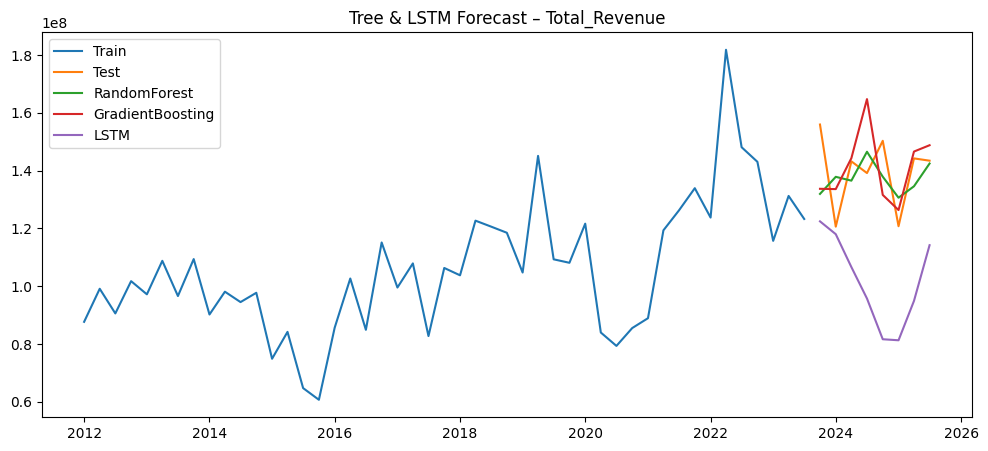

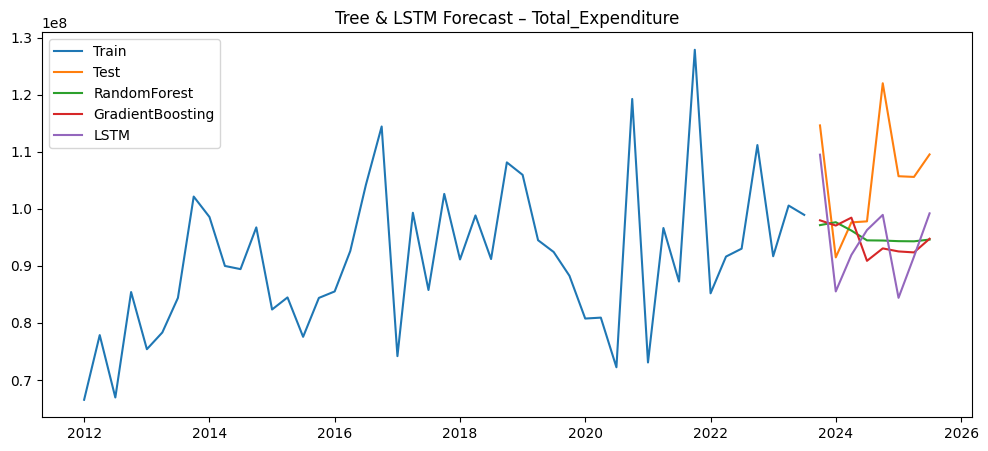

In [11]:
tree_lstm_results = {}

for target in target_vars:
    y_train = train_df[target]
    y_test = test_df[target]

    rf_pred = forecast_tree_model(y_train, horizon=len(y_test), lags=4, model_type="RF")
    gbr_pred = forecast_tree_model(y_train, horizon=len(y_test), lags=4, model_type="GBR")
    lstm_pred = forecast_lstm(y_train, horizon=len(y_test), seq_len=8, hidden_size=50, epochs=200, lr=0.01)

    tree_lstm_results[f"RF_{target}"] = eval_mae(y_test, rf_pred)
    tree_lstm_results[f"GBR_{target}"] = eval_mae(y_test, gbr_pred)
    tree_lstm_results[f"LSTM_{target}"] = eval_mae(y_test, lstm_pred)

    plt.figure(figsize=(12,5))
    plt.plot(y_train, label="Train")
    plt.plot(y_test, label="Test")
    plt.plot(rf_pred, label="RandomForest")
    plt.plot(gbr_pred, label="GradientBoosting")
    plt.plot(lstm_pred, label="LSTM")
    plt.title(f"Tree & LSTM Forecast – {target}")
    plt.legend()
    plt.show()

### 11. Hybrid Best Two Models

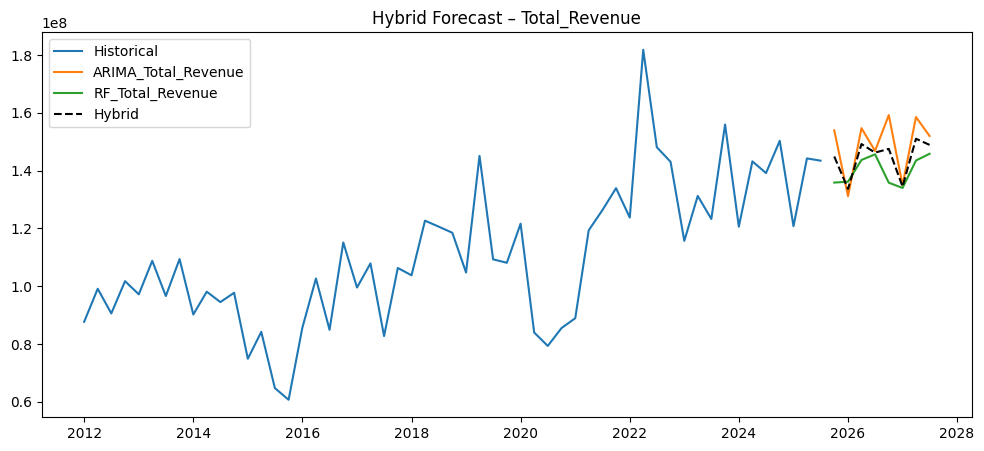

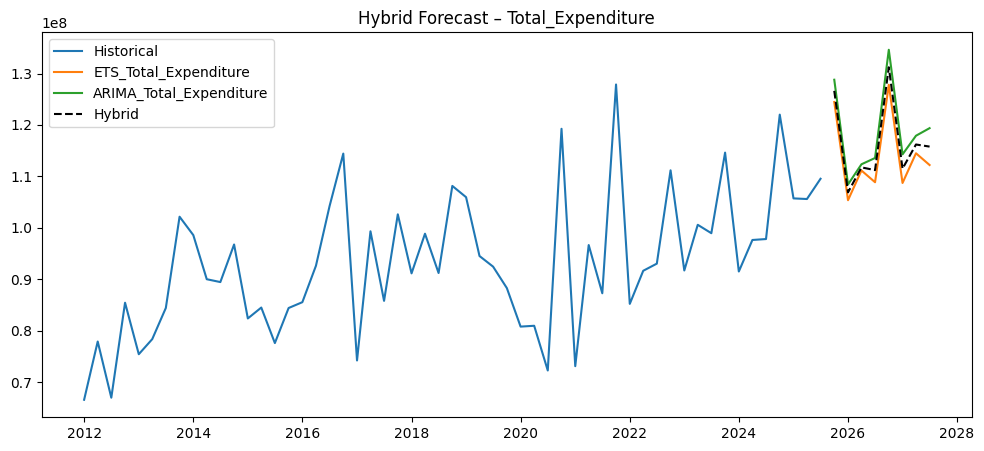

In [12]:
hybrid_results = {}

for target in target_vars:
    # Combine previous MAE results
    all_results = {**results, **tree_lstm_results}
    target_rows = {k:v for k,v in all_results.items() if target in k}
    top2 = sorted(target_rows, key=target_rows.get)[:2]

    preds_list = []
    for model_name in top2:
        if 'ARIMA' in model_name:
            pred = ARIMA(df[target], order=(1,1,1), seasonal_order=(1,1,1,4),
                         enforce_stationarity=False, enforce_invertibility=False).fit().forecast(horizon)
        elif 'ETS' in model_name:
            pred = ExponentialSmoothing(df[target], trend='add', seasonal='add', seasonal_periods=4,
                                        initialization_method='estimated').fit().forecast(horizon)
        elif 'SeasonalNaive' in model_name:
            pred = seasonal_naive(df[target], horizon)
        elif 'RF' in model_name:
            pred = forecast_tree_model(df[target], horizon=horizon, lags=4, model_type='RF')
        elif 'GBR' in model_name:
            pred = forecast_tree_model(df[target], horizon=horizon, lags=4, model_type='GBR')
        elif 'LSTM' in model_name:
            pred = forecast_lstm(df[target], horizon=horizon, seq_len=8, hidden_size=50, epochs=200, lr=0.01)
        preds_list.append(pred)

    hybrid_pred = pd.Series(np.mean(np.column_stack([p.values for p in preds_list]), axis=1),
                            index=pd.date_range(start=df.index[-1]+pd.offsets.QuarterBegin(), periods=horizon, freq='QS'))
    hybrid_results[target] = hybrid_pred

    plt.figure(figsize=(12,5))
    plt.plot(df[target], label="Historical")
    for i, p in enumerate(preds_list):
        plt.plot(p, label=top2[i])
    plt.plot(hybrid_pred, label="Hybrid", linestyle="--", color='black')
    plt.title(f"Hybrid Forecast – {target}")
    plt.legend()
    plt.show()


### MAE Table per Target and Identify Best Model


In [13]:
# Combine all previous results
all_results = {**results, **tree_lstm_results}

# Add Hybrid MAE using test data
for target in target_vars:
    hybrid_pred = hybrid_results[target]
    mae_hybrid = eval_mae(test_df[target], hybrid_pred[:len(test_df)])
    all_results[f"Hybrid_{target}"] = mae_hybrid

# Prepare DataFrame
mae_df = pd.DataFrame([
    {"Model": k, "Target": "_".join(k.split("_")[1:]), "MAE": v} for k,v in all_results.items()
])

# Split tables
revenue_mae = mae_df[mae_df['Target']=="Total_Revenue"].sort_values("MAE").reset_index(drop=True)
expenditure_mae = mae_df[mae_df['Target']=="Total_Expenditure"].sort_values("MAE").reset_index(drop=True)

# Display tables
print("=== MAE Table: Total Revenue ===")
display(revenue_mae)

print("=== MAE Table: Total Expenditure ===")
display(expenditure_mae)

# Identify best model per target
best_models = {
    "Total_Revenue": revenue_mae.loc[0, "Model"],
    "Total_Expenditure": expenditure_mae.loc[0, "Model"]
}

print("=== Best Models ===")
for target, model in best_models.items():
    print(f"{target}: {model}")


=== MAE Table: Total Revenue ===


,Model,Target,MAE
0,Hybrid_Total_Revenue,Total_Revenue,8.240174e+06
1,ARIMA_Total_Revenue,Total_Revenue,8.998117e+06
2,RF_Total_Revenue,Total_Revenue,1.102690e+07
3,SeasonalNaive_Total_Revenue,Total_Revenue,1.139141e+07
4,GBR_Total_Revenue,Total_Revenue,1.174359e+07
5,ETS_Total_Revenue,Total_Revenue,1.656926e+07
6,LSTM_Total_Revenue,Total_Revenue,3.784153e+07


=== MAE Table: Total Expenditure ===


,Model,Target,MAE
0,ETS_Total_Expenditure,Total_Expenditure,4.132465e+06
1,ARIMA_Total_Expenditure,Total_Expenditure,5.838044e+06
2,SeasonalNaive_Total_Expenditure,Total_Expenditure,6.024062e+06
3,Hybrid_Total_Expenditure,Total_Expenditure,1.085058e+07
4,LSTM_Total_Expenditure,Total_Expenditure,1.087552e+07
5,RF_Total_Expenditure,Total_Expenditure,1.169359e+07
6,GBR_Total_Expenditure,Total_Expenditure,1.251056e+07


=== Best Models ===
Total_Revenue: Hybrid_Total_Revenue
Total_Expenditure: ETS_Total_Expenditure


### 12. Forecast 2026 + Last Quarter 2025 using Hybrid (Fixed)


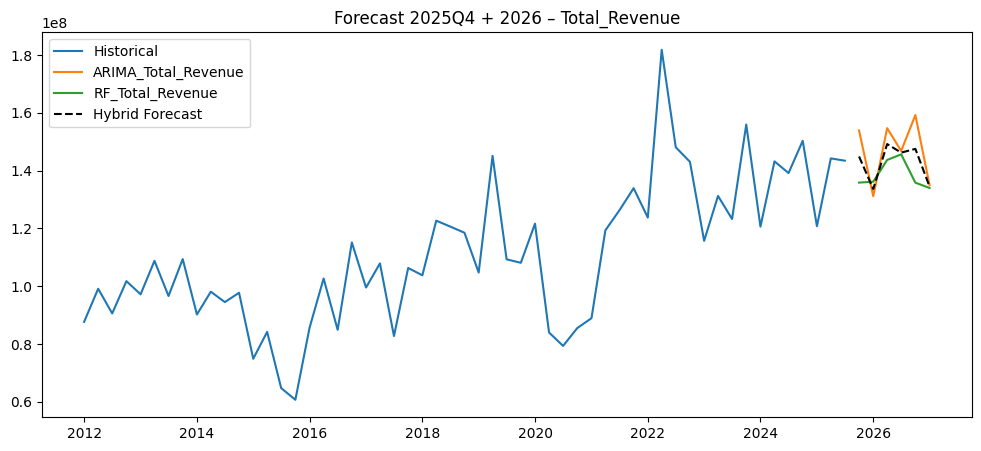

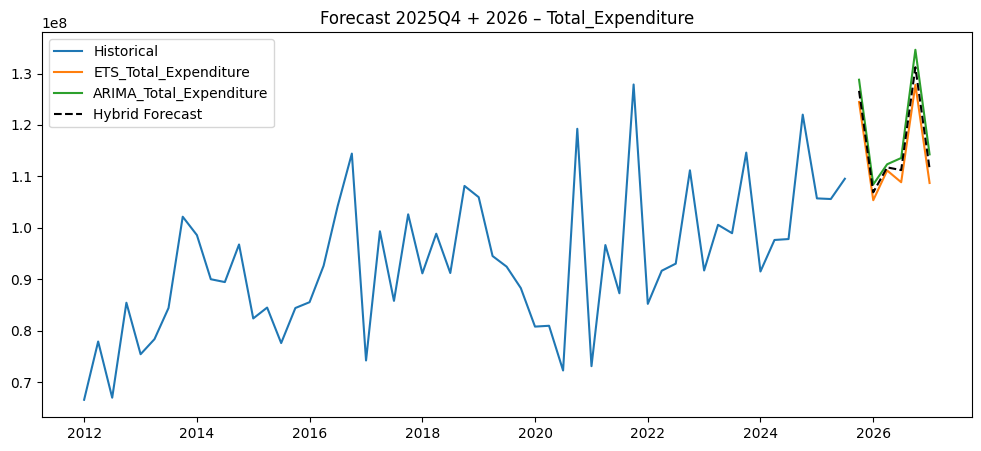

In [14]:
# Compute horizon from last date in data to end of 2026
last_date = df.index.max()
end_2026 = pd.Timestamp('2026-12-31')
horizon_2026 = ((end_2026.year - last_date.year) * 4 + (end_2026.quarter - last_date.quarter) + 1)
if horizon_2026 < 1:
    horizon_2026 = 1

forecast_2026 = {}

for target in target_vars:
    preds_list = []

    # Get top 2 models for this target
    all_results = {**results, **tree_lstm_results}
    target_rows = {k:v for k,v in all_results.items() if target in k}
    if len(target_rows) == 0:
        raise ValueError(f"No models found for target {target}")
    
    top2 = sorted(target_rows, key=target_rows.get)[:2]

    # Generate predictions for top 2 models
    for model_name in top2:
        if 'ARIMA' in model_name:
            pred = ARIMA(df[target], order=(1,1,1), seasonal_order=(1,1,1,4),
                         enforce_stationarity=False, enforce_invertibility=False).fit().forecast(horizon_2026)
            pred = pd.Series(pred.values, index=pd.date_range(start=last_date + pd.offsets.QuarterBegin(), periods=horizon_2026, freq='QS'))
        elif 'ETS' in model_name:
            pred = ExponentialSmoothing(df[target], trend='add', seasonal='add', seasonal_periods=4,
                                        initialization_method='estimated').fit().forecast(horizon_2026)
            pred = pd.Series(pred.values, index=pd.date_range(start=last_date + pd.offsets.QuarterBegin(), periods=horizon_2026, freq='QS'))
        elif 'RF' in model_name:
            pred = forecast_tree_model(df[target], horizon=horizon_2026, lags=4, model_type='RF')
        elif 'GBR' in model_name:
            pred = forecast_tree_model(df[target], horizon=horizon_2026, lags=4, model_type='GBR')
        elif 'LSTM' in model_name:
            pred = forecast_lstm(df[target], horizon=horizon_2026, seq_len=8, hidden_size=50, epochs=200, lr=0.01)
        else:
            continue

        preds_list.append(pred)

    # Ensure at least one prediction exists
    if len(preds_list) == 0:
        raise ValueError(f"No predictions generated for target {target}")

    # Hybrid = average of top 2 model predictions
    hybrid_pred = pd.Series(
        np.mean(np.column_stack([p.values for p in preds_list]), axis=1),
        index=pd.date_range(start=last_date + pd.offsets.QuarterBegin(), periods=horizon_2026, freq='QS')
    )
    forecast_2026[target] = hybrid_pred

    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(df[target], label="Historical")
    for i, p in enumerate(preds_list):
        plt.plot(p, label=top2[i])
    plt.plot(hybrid_pred, label="Hybrid Forecast", linestyle="--", color='black')
    plt.title(f"Forecast 2025Q4 + 2026 – {target}")
    plt.legend()
    plt.show()


### Interactive Forecast: Train, Test, All Models (Hybrid Included)


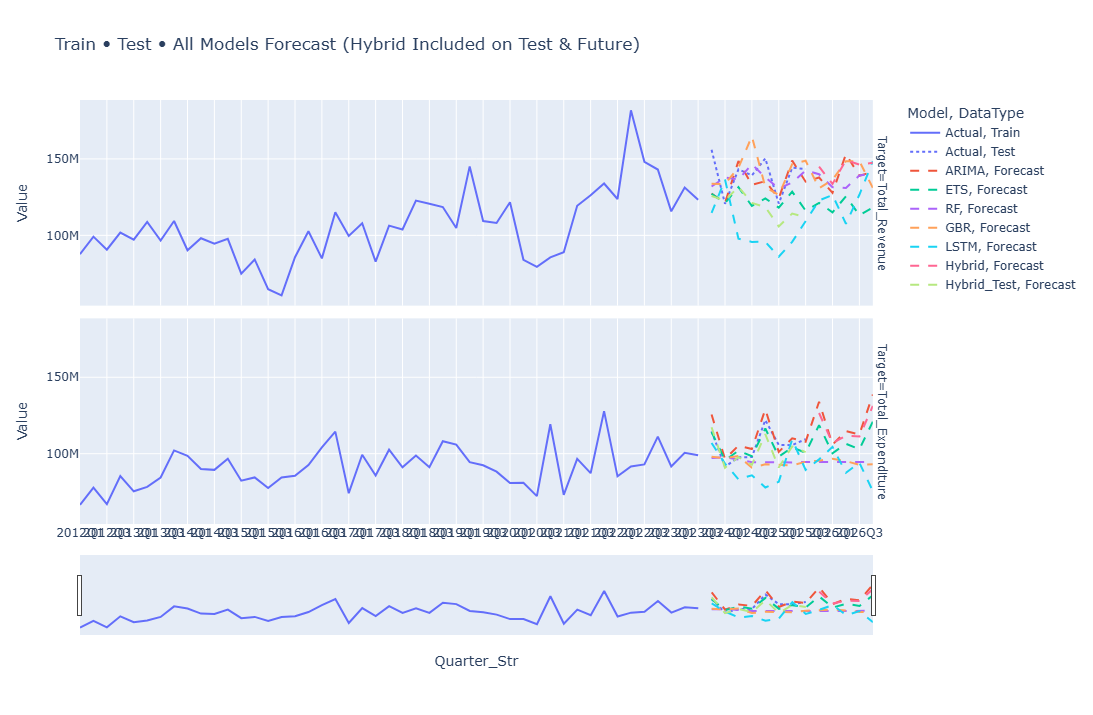

In [15]:
import plotly.express as px
import pandas as pd

all_models_forecasts = []

for target in target_vars:

    # ============================
    # 1) TRAIN DATA
    # ============================
    df_train = train_df[[target]].copy()
    df_train = df_train.rename(columns={target:'Value'})
    df_train['Model'] = 'Actual'
    df_train['DataType'] = 'Train'
    df_train['Target'] = target
    df_train['Quarter_Str'] = df_train.index.to_series().dt.to_period('Q').astype(str)
    all_models_forecasts.append(df_train)

    # ============================
    # 2) TEST DATA
    # ============================
    df_test = test_df[[target]].copy()
    df_test = df_test.rename(columns={target:'Value'})
    df_test['Model'] = 'Actual'
    df_test['DataType'] = 'Test'
    df_test['Target'] = target
    df_test['Quarter_Str'] = df_test.index.to_series().dt.to_period('Q').astype(str)
    all_models_forecasts.append(df_test)

    # ============================
    # 3) FORECAST HORIZONS
    # ============================
    last_train_date = train_df.index[-1]

    end_2026 = pd.Timestamp("2026-12-31")
    horizon_full = (end_2026.year - last_train_date.year) * 4 + (end_2026.quarter - last_train_date.quarter) + 1

    horizon_test = len(test_df)

    # ============================
    # 4) MODEL FORECASTS (FULL HORIZON)
    # ============================

    # ---- ARIMA ----
    arima_model = ARIMA(train_df[target], order=(1,1,1),
                        seasonal_order=(1,1,1,4),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit()

    arima_pred_full = arima_model.forecast(horizon_full)
    arima_pred_full = pd.Series(arima_pred_full.values,
                                index=pd.date_range(start=last_train_date + pd.offsets.QuarterBegin(),
                                                    periods=horizon_full, freq='QS'))

    # ---- ETS ----
    ets_model = ExponentialSmoothing(train_df[target], trend='add', seasonal='add',
                                     seasonal_periods=4,
                                     initialization_method='estimated').fit()

    ets_pred_full = ets_model.forecast(horizon_full)
    ets_pred_full = pd.Series(ets_pred_full.values,
                              index=pd.date_range(start=last_train_date + pd.offsets.QuarterBegin(),
                                                  periods=horizon_full, freq='QS'))

    # ---- RF ----
    rf_pred_full = forecast_tree_model(train_df[target], horizon=horizon_full, lags=4, model_type="RF")

    # ---- GBR ----
    gbr_pred_full = forecast_tree_model(train_df[target], horizon=horizon_full, lags=4, model_type="GBR")

    # ---- LSTM ----
    lstm_pred_full = forecast_lstm(train_df[target], horizon=horizon_full,
                                   seq_len=8, hidden_size=50, epochs=200, lr=0.01)

    # ============================
    # 5) HYBRID MODELS
    # ============================

    # ---- Hybrid Test Horizon ----
    arima_test = arima_model.forecast(horizon_test)
    lstm_test = forecast_lstm(train_df[target], horizon=horizon_test,
                               seq_len=8, hidden_size=50, epochs=200, lr=0.01)

    hybrid_test = (pd.Series(arima_test.values) + pd.Series(lstm_test.values)) / 2
    hybrid_test.index = pd.date_range(start=last_train_date + pd.offsets.QuarterBegin(),
                                      periods=horizon_test, freq='QS')

    # ---- Hybrid Full Horizon (your existing results) ----
    hybrid_pred_full = hybrid_results[target].copy()
    hybrid_pred_full = hybrid_pred_full[(hybrid_pred_full.index >= last_train_date) &
                                        (hybrid_pred_full.index <= end_2026)]

    # ============================
    # 6) ADD ALL FORECASTS TO MASTER LIST
    # ============================
    model_preds = {
        "ARIMA": arima_pred_full,
        "ETS": ets_pred_full,
        "RF": rf_pred_full,
        "GBR": gbr_pred_full,
        "LSTM": lstm_pred_full,
        "Hybrid": hybrid_pred_full,          # Full forecast
        "Hybrid_Test": hybrid_test           # Test area hybrid
    }

    for model_name, pred_series in model_preds.items():
        df_model = pd.DataFrame({
            "Value": pred_series.values,
            "Model": model_name,
            "Target": target,
            "DataType": "Forecast",
            "Quarter_Str": pred_series.index.to_series().dt.to_period("Q").astype(str)
        }, index=pred_series.index)

        all_models_forecasts.append(df_model)

# ============================
# 7) COMBINE EVERYTHING
# ============================
interactive_df = pd.concat(all_models_forecasts).reset_index().rename(columns={"index":"Date"})
interactive_df["Year"] = interactive_df["Date"].dt.year
interactive_df = interactive_df[interactive_df["Year"] <= 2026]

# ============================
# 8) PLOT
# ============================
fig = px.line(
    interactive_df,
    x="Quarter_Str",
    y="Value",
    color="Model",
    line_dash="DataType",
    facet_row="Target",
    title="Train • Test • All Models Forecast (Hybrid Included on Test & Future)"
)

fig.update_layout(height=700, width=1100)

# ---- REMOVE EXTRA SLIDERS FOR FACETS ----
for ax in fig.layout:
    if "xaxis" in ax and ax != "xaxis":
        fig.layout[ax].rangeslider.visible = False

# ---- KEEP ONLY ONE SLIDER ----
fig.layout.xaxis.rangeslider.visible = True

fig.update_xaxes(tickangle=0)

fig.show()


### Best Model per Variable + User Input Forecast

##### PART A — Compute BEST model per variable (based on Test MAE)


In [17]:
from sklearn.metrics import mean_absolute_error

best_model_single = {}  # {target: best_model}

for target in target_vars:
    mae_scores = {}
    
    test_index = test_df.index
    horizon_test = len(test_df)

    # ----- Forecast test horizon for all models -----
    # ARIMA
    arima_model = ARIMA(train_df[target], order=(1,1,1),
                        seasonal_order=(1,1,1,4),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit()
    arima_test_pred = arima_model.forecast(horizon_test)
    arima_test_pred.index = test_index
    mae_scores["ARIMA"] = mean_absolute_error(test_df[target], arima_test_pred)

    # ETS
    ets_model = ExponentialSmoothing(train_df[target], trend='add',
                                     seasonal='add', seasonal_periods=4,
                                     initialization_method='estimated').fit()
    ets_test_pred = ets_model.forecast(horizon_test)
    ets_test_pred.index = test_index
    mae_scores["ETS"] = mean_absolute_error(test_df[target], ets_test_pred)

    # RF
    rf_test_pred = forecast_tree_model(train_df[target], horizon=horizon_test,
                                       lags=4, model_type="RF")
    rf_test_pred.index = test_index
    mae_scores["RF"] = mean_absolute_error(test_df[target], rf_test_pred)

    # GBR
    gbr_test_pred = forecast_tree_model(train_df[target], horizon=horizon_test,
                                        lags=4, model_type="GBR")
    gbr_test_pred.index = test_index
    mae_scores["GBR"] = mean_absolute_error(test_df[target], gbr_test_pred)

    # LSTM
    lstm_test_pred = forecast_lstm(train_df[target], horizon=horizon_test,
                                   seq_len=8, hidden_size=50, epochs=200, lr=0.01)
    lstm_test_pred.index = test_index
    mae_scores["LSTM"] = mean_absolute_error(test_df[target], lstm_test_pred)

    # Hybrid
    hybrid_test = (arima_test_pred.values + lstm_test_pred.values) / 2
    hybrid_test = pd.Series(hybrid_test, index=test_index)
    mae_scores["Hybrid"] = mean_absolute_error(test_df[target], hybrid_test)

    # Pick best model (lowest MAE)
    best_model_single[target] = min(mae_scores, key=mae_scores.get)



##### PART B — Function to return best model forecast for a given quarter


In [18]:
def format_number(n):
    """Format number to human readable form: 1,000,000 → 1M"""
    if n >= 1_000_000:
        return f"{round(n/1_000_000,1)}M"
    elif n >= 1_000:
        return f"{round(n/1_000,1)}K"
    else:
        return str(round(n,0))

def get_best_forecast(year, quarter):
    """Return forecast of best model only in human-readable format"""
    quarter_str = f"{year}Q{quarter}"
    results_output = {}

    for target in target_vars:
        best_model_name = best_model_single[target]
        df_target = interactive_df[(interactive_df["Target"] == target)]

        row = df_target[
            (df_target["Model"] == best_model_name) &
            (df_target["Quarter_Str"] == quarter_str)
        ]

        if not row.empty:
            val = float(row["Value"].values[0])
            results_output[target] = format_number(val)
        else:
            results_output[target] = None

    return results_output

##### PART C — User input interface

In [20]:
def format_large_number(n):
    """Format number with commas and add B/M/K suffix."""
    if n >= 1_000_000_000:
        return f"{n/1_000_000_000:,.1f}B"
    elif n >= 1_000_000:
        return f"{n/1_000_000:,.1f}M"
    elif n >= 1_000:
        return f"{n/1_000:,.1f}K"
    else:
        return f"{n:,.0f}"

try:
    # Take user input
    year_input = int(input("Enter Year (e.g., 2026): "))
    quarter_input = int(input("Enter Quarter (1-4): "))

    if quarter_input not in [1, 2, 3, 4]:
        raise ValueError("Quarter must be between 1 and 4.")

    # Convert input to Quarter_Str
    quarter_str = f"{year_input}Q{quarter_input}"
    results_output = {}

    for target in target_vars:
        best_model_name = best_model_single[target]
        df_target = interactive_df[interactive_df["Target"] == target]

        row = df_target[
            (df_target["Model"] == best_model_name) &
            (df_target["Quarter_Str"] == quarter_str)
        ]

        if not row.empty:
            numeric_val = float(row["Value"].values[0])
            # Format nicely
            results_output[target] = format_large_number(numeric_val)
        else:
            results_output[target] = None

    # Print results
    for target, value in results_output.items():
        if value is not None:
            print(f"{target}: {value}")
        else:
            print(f"{target}: No forecast available")

except Exception as e:
    print(f"Error: {e}")


Enter Year (e.g., 2026):  2025
Enter Quarter (1-4):  4


Total_Revenue: 137.9M
Total_Expenditure: 118.7M


### Detailed Forecasting

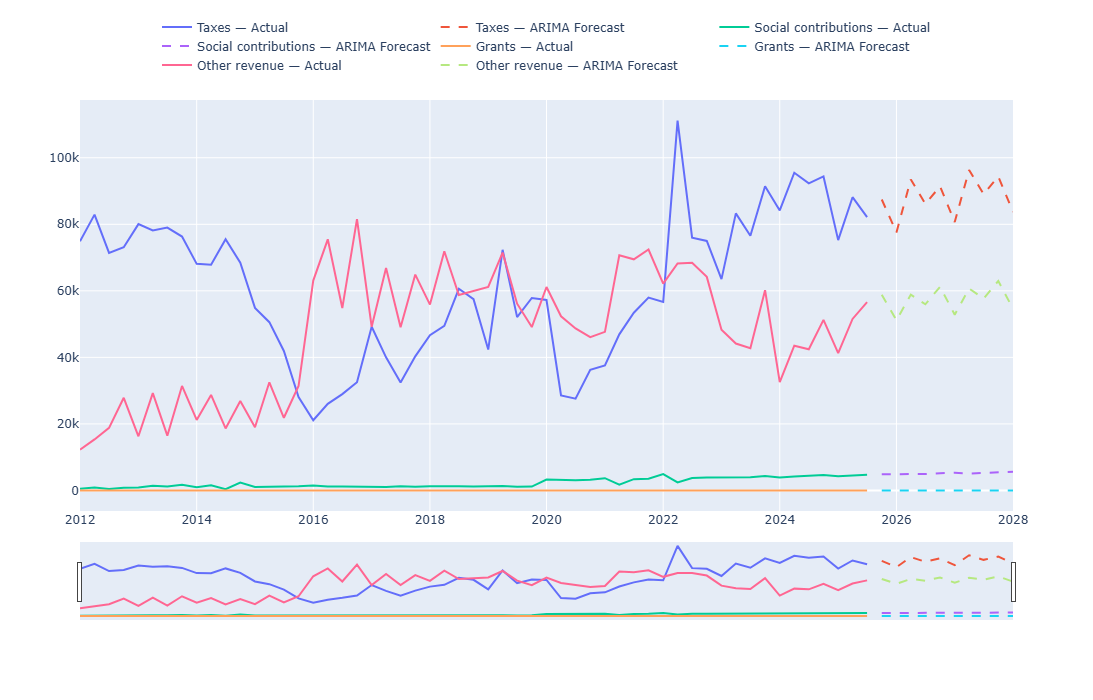

In [34]:
import pandas as pd
import plotly.graph_objs as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ============================================
# 1 — Define Columns
# ============================================
revenue_cols = ["Taxes","Social contributions","Grants","Other revenue"]
expense_cols = [
    "Compensation of employees","Use of goods and services",
    "Consumption of fixed capital","Interest","Subsidies",
    "Grants.1","Social benefits","Other expense"
]

all_cols = revenue_cols + expense_cols
df = df.copy()

# ============================================
# 2 — FIX THE INDEX
# ============================================
if "Year" in df.columns and "Quarter" in df.columns:
    df.index = pd.to_datetime(df["Year"].astype(str) + "-" + df["Quarter"].astype(str))
    df = df.drop(columns=["Year","Quarter"])
else:
    df.index = pd.to_datetime(df.index)

df = df[all_cols]

# ============================================
# 3 — Train/Test Split
# ============================================
train_df = df
last_train_date = train_df.index[-1]

# ============================================
# 4 — Forecast functions
# ============================================
def forecast_arima(series, horizon):
    model = SARIMAX(series, order=(1,1,1),
                    seasonal_order=(1,1,1,4),
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit(disp=False)
    return model.forecast(horizon)

def forecast_ets(series, horizon):
    model = ExponentialSmoothing(
        series, trend="add",
        seasonal="add", seasonal_periods=4
    ).fit()
    return model.forecast(horizon)

# ============================================
# 5 — Helper function to create figure
# ============================================
def plot_forecast(columns, model_func, model_name):
    traces = []
    # Compute horizon until end of 2027
    end_2027 = pd.Timestamp("2027-12-31")
    horizon_full = (end_2027.year - last_train_date.year) * 4 + (end_2027.quarter - last_train_date.quarter) + 1
    forecast_index = pd.date_range(start=last_train_date + pd.offsets.QuarterBegin(), periods=horizon_full, freq='QS')
    
    for col in columns:
        # Actual
        traces.append(go.Scatter(
            x=df.index, y=df[col],
            mode="lines", name=f"{col} — Actual"
        ))
        # Forecast
        pred = model_func(train_df[col], horizon_full)
        pred.index = forecast_index
        traces.append(go.Scatter(
            x=pred.index, y=pred.values,
            mode="lines", name=f"{col} — {model_name} Forecast",
            line=dict(dash="dash")
        ))
    fig = go.Figure(traces)
    fig.update_layout(
        # title=f"{model_name} Forecasts — {'Revenue' if columns==revenue_cols else 'Expenses'}",
        height=700,
        xaxis=dict(rangeslider=dict(visible=True), type="date"),
        legend=dict(orientation="h", y=1.05, x=0.5, xanchor="center")
    )
    fig.show()

# ============================================
# 6 — Create Forecast Charts
# ============================================
plot_forecast(revenue_cols, forecast_arima, "ARIMA")


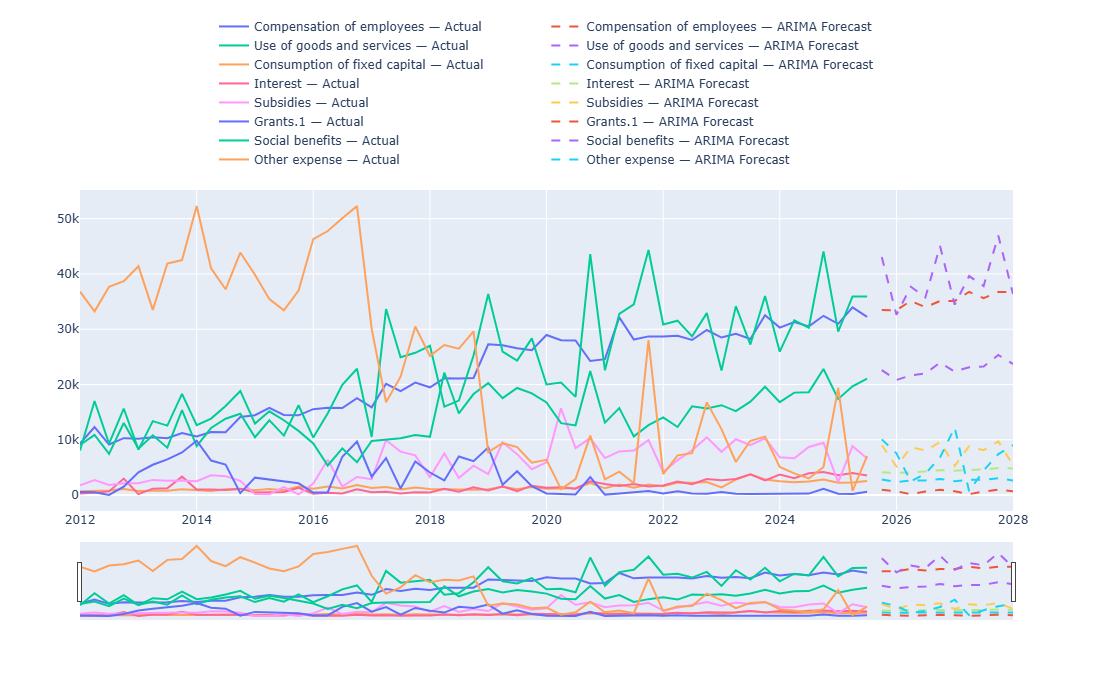

In [35]:
plot_forecast(expense_cols, forecast_arima, "ARIMA")


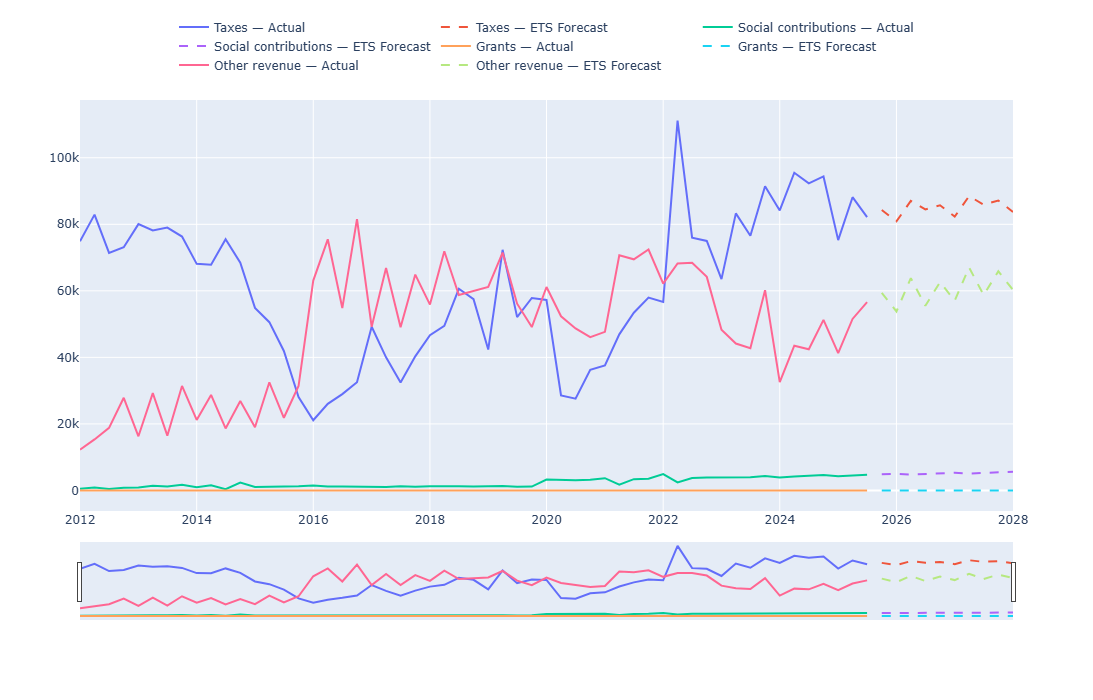

In [36]:
plot_forecast(revenue_cols, forecast_ets, "ETS")


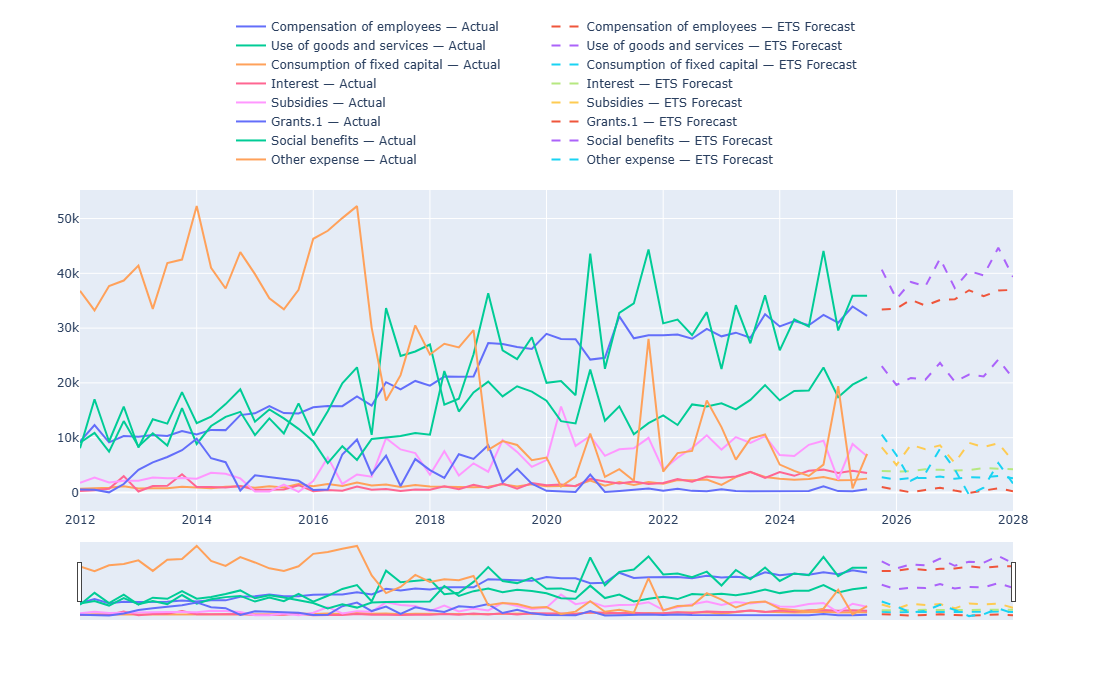

In [37]:
plot_forecast(expense_cols, forecast_ets, "ETS")

### User Input — Select variable, year, quarter

In [49]:
# ============================================
# User Input — Select variable, year, quarter (with error handling)
# ============================================

while True:
    try:
        print("Available variables:")
        for i, col in enumerate(all_cols, 1):
            print(f"{i}. {col}")
        var_choice = input("Enter the variable name (exactly as shown above): ")
        if var_choice not in all_cols:
            raise ValueError(f"Variable '{var_choice}' not found. Please select from the available list.")

        year_choice = int(input("Enter the year (e.g., 2027): "))
        quarter_choice = int(input("Enter the quarter (1-4): "))
        if quarter_choice not in [1,2,3,4]:
            raise ValueError("Quarter must be 1, 2, 3, or 4.")

        # Convert quarter to timestamp
        month_map = {1: 1, 2: 4, 3: 7, 4: 10}
        date_choice = pd.Timestamp(f"{year_choice}-{month_map[quarter_choice]}-01")
        break  # exit loop if all inputs are valid
    except Exception as e:
        print(f"Input error: {e}. Please try again.\n")

# ============================================
# Get value (historical or forecast)
# ============================================
def get_value(var_name, date):
    # Historical data
    if date in df.index:
        return float(df.loc[date, var_name]), "Historical"
    
    # Forecast horizon
    end_2027 = pd.Timestamp("2027-12-31")
    horizon_full = (end_2027.year - last_train_date.year) * 4 + (end_2027.quarter - last_train_date.quarter) + 1
    forecast_index = pd.date_range(start=last_train_date + pd.offsets.QuarterBegin(), periods=horizon_full, freq='QS')
    
    if date not in forecast_index:
        return None, "Date out of forecast range"

    # ARIMA forecast
    arima_pred = forecast_arima(train_df[var_name], horizon_full)
    arima_pred.index = forecast_index
    arima_val = float(arima_pred.loc[date])

    # ETS forecast
    ets_pred = forecast_ets(train_df[var_name], horizon_full)
    ets_pred.index = forecast_index
    ets_val = float(ets_pred.loc[date])
    
    return (arima_val, ets_val), "Forecast"

# ============================================
# Format number function
# ============================================
def format_number(n):
    if n is None:
        return "N/A"
    if n >= 1_000_000_000:
        return f"{round(n/1_000_000_000,1)}B"
    elif n >= 1_000_000:
        return f"{round(n/1_000_000,1)}M"
    elif n >= 1_000:
        return f"{round(n/1_000,1)}K"
    else:
        return str(round(n,0))

# ============================================
# Display results
# ============================================
value, status = get_value(var_choice, date_choice)

if status == "Historical":
    print(f"\nActual value of '{var_choice}' in {year_choice} Q{quarter_choice}: {format_number(value)}")
elif status == "Forecast":
    arima_val, ets_val = value
    print(f"\nForecast for '{var_choice}' in {year_choice} Q{quarter_choice}:")
    print(f"ARIMA: {format_number(arima_val)}")
    print(f"ETS  : {format_number(ets_val)}")
else:
    print(f"Date {year_choice} Q{quarter_choice} is out of forecast range.")


Available variables:
1. Taxes
2. Social contributions
3. Grants
4. Other revenue
5. Compensation of employees
6. Use of goods and services
7. Consumption of fixed capital
8. Interest
9. Subsidies
10. Grants.1
11. Social benefits
12. Other expense


Enter the variable name (exactly as shown above):  Taxes
Enter the year (e.g., 2027):  2025
Enter the quarter (1-4):  1



Actual value of 'Taxes' in 2025 Q1: 75.2K
